# K-Means

## Ví dụ 1:

In [13]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(11)
# Kỳ vọng và hiệp phương sai của 3 cụm dữ liệu
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
# Số điểm mỗi cụm dữ liệu
N = 500
# Tạo các cụm dữ liệu qua phân bố chuẩn (Gaussian)
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# Tổng hợp dữ liệu từ các cụm
X = np.concatenate((X0, X1, X2), axis = 0)
# Số cụm = 3
K = 3
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [4]:
def kmeans_display(X, label):
  K = np.amax(label) + 1
  X0 = X[label == 0, :]
  X1 = X[label == 1, :]
  X2 = X[label == 2, :]
  plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
  plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
  plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
  plt.axis('equal')
  plt.plot()
  plt.show()

In [5]:
def kmeans_init_centers(X, k):
  # randomly pick k rows of X as initial centers
  return X[np.random.choice(X.shape[0], k, replace=False)]

In [6]:
def kmeans_assign_labels(X, centers):
  # calculate pairwise distances btw data and centers
  D = cdist(X, centers)
  # return index of the closest center
  return np.argmin(D, axis = 1)

In [7]:
def kmeans_update_centers(X, labels, K):
  centers = np.zeros((K, X.shape[1]))
  for k in range(K):
    # collect all points assigned to the k-th cluster
    Xk = X[labels == k, :]
    # take average
    centers[k,:] = np.mean(Xk, axis = 0)
  return centers

In [8]:
def has_converged(centers, new_centers, tol = 1e-4):
# return True if two sets of centers are the same
  return np.linalg.norm(centers - new_centers) < tol

In [9]:
def kmeans(X, K, max_iter = 1000):
  centers = [kmeans_init_centers(X, K)]
  labels = []
  it = 0
  while it < max_iter:
    labels.append(kmeans_assign_labels(X, centers[-1]))
    new_centers = kmeans_update_centers(X, labels[-1], K)
    if has_converged(centers[-1], new_centers):
      break
    centers.append(new_centers)
    it += 1
  return (centers, labels, it)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


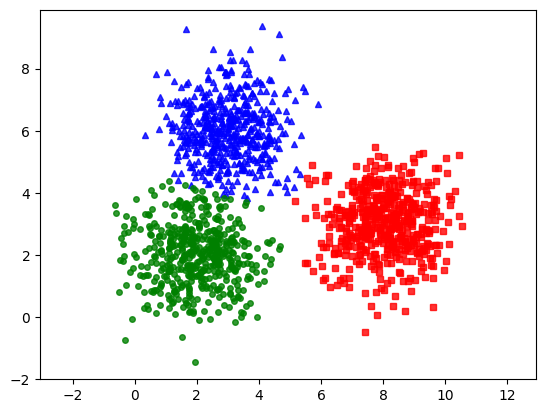

In [15]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(X, labels[-1])

## Thư viện sklearn

Centers found by scikit-learn:
[[1.97826939 2.00223913]
 [2.98759958 6.02896527]
 [8.0410628  3.02094748]]


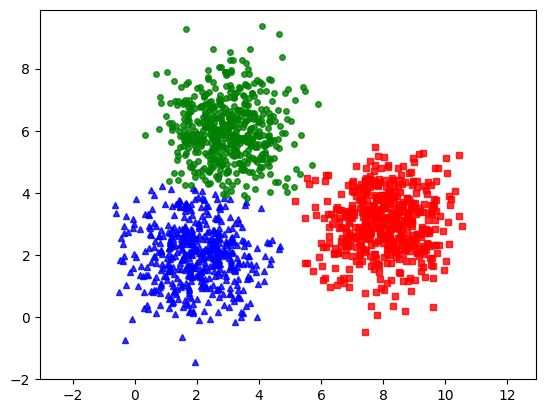

In [16]:
from sklearn.cluster import KMeans
kmeanslib = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeanslib.cluster_centers_)
pred_label = kmeanslib.predict(X)
kmeans_display(X, pred_label)

## Ví dụ 2

In [17]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib


In [18]:

# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.
# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.

# source: https://github.com/tsaith/ufldl_tutorial
def display_network(A, m = -1, n = -1):
  opt_normalize = True
  opt_graycolor = True
  # Rescale
  A = A - np.average(A)
  # Compute rows & cols
  (row, col) = A.shape
  sz = int(np.ceil(np.sqrt(row)))
  buf = 1
  if m < 0 or n < 0:
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)

  image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
  if not opt_graycolor:
    image *= 0.1
  k = 0
  for i in range(int(m)):
    for j in range(int(n)):
      if k >= col:
        continue
      clim = np.max(np.abs(A[:, k]))
      if opt_normalize:
        image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = A[:, k].reshape(sz, sz) / clim
      else:
        image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = A[:, k].reshape(sz, sz) / np.max(np.abs(A))
      k += 1
  return image

In [19]:
def display_color_network(A):
  """
  # display receptive field(s) or basis vector(s) for image patches
  #
  # A the basis, with patches as column vectors
  # In case the midpoint is not set at 0, we shift it dynamically
  :param A:
  :param file:
  :return:
  """
  if np.min(A) >= 0:
    A = A - np.mean(A)
  cols = np.round(np.sqrt(A.shape[1]))
  channel_size = A.shape[0] / 3
  dim = np.sqrt(channel_size)
  dimp = dim + 1
  rows = np.ceil(A.shape[1] / cols)
  B = A[0:channel_size, :]

  C = A[channel_size:2 * channel_size, :]
  D = A[2 * channel_size:3 * channel_size, :]
  B = B / np.max(np.abs(B))
  C = C / np.max(np.abs(C))
  D = D / np.max(np.abs(D))
  # Initialization of the image
  image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))
  for i in range(int(rows)):
    for j in range(int(cols)):
  # This sets the patch
      image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols
      + j].reshape(dim, dim)
      image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols
      + j].reshape(dim, dim)
      image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols
      + j].reshape(dim, dim)
      image = (image + 1) / 2
  return image

In [20]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)
X0 = np.asarray(X)[:1000,:]/256.0
X = X0
y = y[:1000]
K = 10
kmeanslib = KMeans(n_clusters=K).fit(X)
pred_label = kmeanslib.predict(X)


In [21]:
print(X.shape)
print(y.shape)

(1000, 784)
(1000,)


<class 'numpy.ndarray'>
(784, 10)


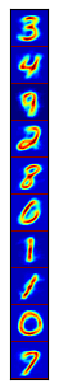

In [22]:
print(type(kmeanslib.cluster_centers_.T))
print(kmeanslib.cluster_centers_.T.shape)
A = display_network(kmeanslib.cluster_centers_.T, K, 1)
f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')
# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())
# map the normalized data to colors
# image is now RGBA (512x512x4)
image = cmap(norm(A)) 
N0 = 20
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))
for k in range(K):
  Xk = X0[pred_label == k, :]
  center_k = [kmeanslib.cluster_centers_[k]]
  neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)
  dist, nearest_id = neigh.kneighbors(center_k, N0)
  X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
  X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

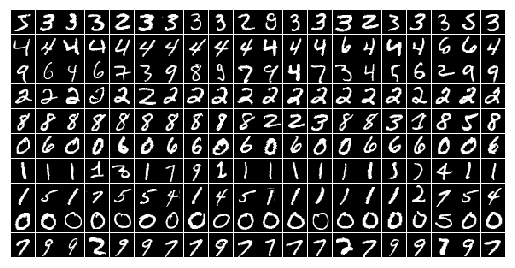

In [23]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

## Bài 1.1

In [24]:
X_T = X.T
K2 = 10
(centers2, labels2, it2) = kmeans(X_T, K2)
print('Centers:')
print(centers2[-1])


Centers:
[[0.37597656 0.40592448 0.13053385 ... 0.77647569 0.16688368 0.29720052]
 [0.22198933 0.08822409 0.1476753  ... 0.18121189 0.2648628  0.58269817]
 [0.678125   0.8171875  0.06067708 ... 0.66145833 0.50195312 0.38997396]
 ...
 [0.05942235 0.64749053 0.1397964  ... 0.36943655 0.29083807 0.09339489]
 [0.60072545 0.42843192 0.19308036 ... 0.00488281 0.61300223 0.02050781]
 [0.02155671 0.64033565 0.46657986 ... 0.68084491 0.15176505 0.17259838]]


## Bài 1.2

In [16]:
import numpy as np
import cv2
import os

filepath = '/home/vitquay1708/Study_Space/ml/week_10/data/cats_and_dogs_filtered'
folders = ['train/cats', 'train/dogs', 'validation/cats', 'validation/dogs']
IMG_SIZE = 64
D = IMG_SIZE ** 2

image_paths = []
labels = []

for folder in folders:
  folder_path = os.path.join(filepath, folder)
  file_names = os.listdir(folder_path)

  for file in file_names:
    full_path = os.path.join(folder_path, file)
    image_paths.append(full_path)
    if 'cat' in str(file):
      labels.append(0)
    else:
      labels.append(1)

N = len(image_paths)

X = np.zeros((D, N), dtype=np.float32)
y = np.array(labels, dtype=np.int8)

count = 0
for i, img_path in enumerate(image_paths):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  if img is not None:
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X[:, i] = img.reshape(D)
    count += 1
  else:
    print(f'Khong doc duoc file {img_path}')

X = X.T
X = X / 255.0
print(X.shape)
print(y.shape)


(3000, 4096)
(3000,)


In [19]:
(centers3, labels3, _) = kmeans(X, 2)
print('Centers:')
print(centers3[-1][0])
print(centers3[-1][1])

Centers:
[0.56338519 0.5689925  0.57221401 ... 0.57378793 0.56811595 0.56389093]
[0.30694261 0.30481297 0.30919322 ... 0.37431031 0.36727902 0.36605102]


# DBScan

## Ví dụ 2.1

In [25]:
import numpy as np
from matplotlib import pyplot as plt

class DBSCAN(object):

    def __init__(self,x,epsilon,minpts):
        # The number of input dataset
        self.n = len(x)
        # Euclidean distance
        p, q = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.dist = np.sqrt(np.sum(((x[p] - x[q])**2),2))
        # label as visited points and noise
        self.visited = np.full((self.n), False)
        self.noise = np.full((self.n),False)
        # DBSCAN Parameters
        self.epsilon = epsilon
        self.minpts = minpts
        # Cluseter
        self.idx = np.full((self.n),0)
        self.C = 0
        self.input = x

    def run(self):
        # Clustering
        for i in range(len(self.input)):
            if self.visited[i] == False:
                self.visited[i] = True
                self.neighbors = self.regionQuery(i)
                if len(self.neighbors) >= self.minpts:
                    self.C += 1
                    self.expandCluster(i)
                else : self.noise[i] = True
        return self.idx,self.noise

    def regionQuery(self, i):
        g = self.dist[i,:] < self.epsilon
        Neighbors = np.where(g)[0].tolist()
        return Neighbors

    def expandCluster(self, i):
        self.idx[i] = self.C
        k = 0
       
        while True:
            if len(self.neighbors) <= k:return
            j = self.neighbors[k]
            if self.visited[j] != True:
                self.visited[j] = True

                self.neighbors2 = self.regionQuery(j)
                v = [self.neighbors2[i] for i in np.where(self.idx[self.neighbors2]==0)[0]]

                if len(self.neighbors2) >=  self.minpts:
                    self.neighbors = self.neighbors+v

            if self.idx[j] == 0 : self.idx[j] = self.C
            k += 1

    def sort(self):
        
        cnum = np.max(self.idx)
        self.cluster = []
        self.noise = []
        for i in range(cnum):
           
            k = np.where(self.idx == (i+1))[0].tolist()
            self.cluster.append([self.input[k,:]])
       
        self.noise = self.input[np.where(self.idx == 0)[0].tolist(),:]
        return self.cluster, self.noise

    def plot(self):
        
        self.sort()
        fig,ax = plt.subplots()
        
        for idx,group in enumerate(self.cluster):
        
            ax.plot(group[0][:,0],
                    group[0][:,1],
                    marker='o',
                    linestyle='',
                    label='Cluster {}'.format(idx))

            if self.noise.size > 0:
                ax.plot(self.noise[:,0],
                    self.noise[:,1],
                    marker='x',
                    linestyle='',
                    label='noise')

        ax.legend(fontsize=10, loc='upper left')
        plt.title('Scatter Plot of Clustering result', fontsize=15)
        plt.xlabel('X', fontsize=14)
        plt.ylabel('Y', fontsize=14)
        plt.show()

### Data 1

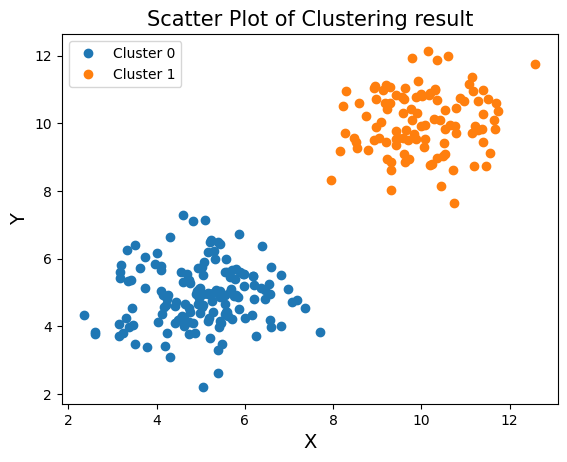

In [26]:
from scipy import io
import pandas as pd

# Load data
df = pd.read_csv('/home/vitquay1708/Study_Space/ml/week_10/data/input.csv')
x = np.zeros([len(df), 2], float )
x[:, 0] = np.array(df['x1'], float)
x[:, 1] = np.array(df['x2'], float)
#%% Run DEMO
# INIT DBSCAN
dbscan = DBSCAN(x,1.5,4)
# CLUSTERING
idx,noise = dbscan.run()
# SORTING
g_cluster,n_cluster = dbscan.sort()
# Visualization
dbscan.plot()

### K_means data 1

Centers:
[[ 5.02487793  4.89668156]
 [10.01018716 10.04928426]]


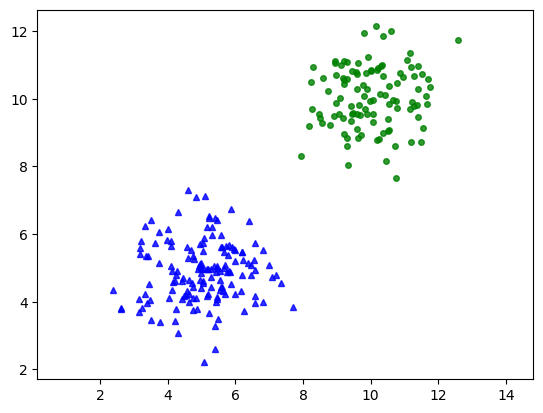

In [32]:
(centers3, labels3, it3) = kmeans(x, 2)
print('Centers:')
print(centers3[-1])
kmeans_display(x, labels3[-1])

### Data 2

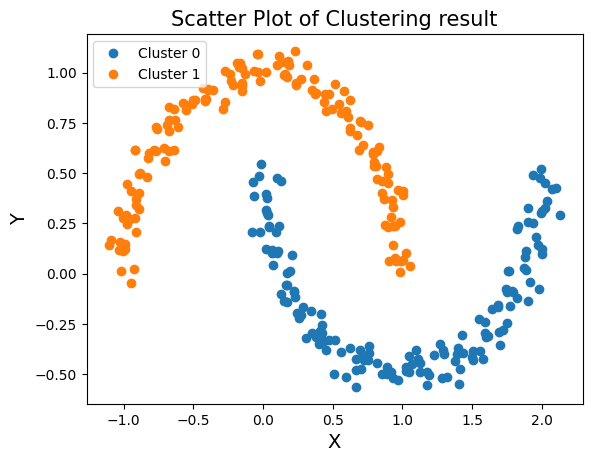

In [44]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# INIT DBSCAN
dbscan = DBSCAN(X, 0.3, 5)
# CLUSTERING
idx,noise = dbscan.run()
# SORTING
g_cluster,n_cluster = dbscan.sort()
# Visualization
dbscan.plot()

### K_means data 2

[[ 1.20732539 -0.07380461]
 [-0.19713697  0.57586492]]
[array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1

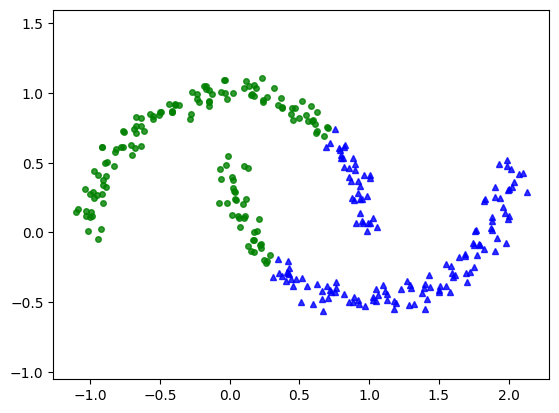

In [45]:
(centers4, labels4, it4) = kmeans(X, 2)
print(centers4[-1])
print(labels4)
kmeans_display(X, labels4[-1])

## Ví dụ 2.2

In [54]:
df_sales = pd.read_csv('/home/vitquay1708/Study_Space/ml/week_10/data/Sales_Transactions_Dataset_Weekly.csv')
print(df_sales.shape)
print(df_sales.dtypes)

X = []
for col in df_sales.columns:
  if df_sales[col].dtypes == 'float64':
    X.append(df_sales[col])
X = np.array(X).T
print(X.shape)

(811, 107)
Product_Code      object
W0                 int64
W1                 int64
W2                 int64
W3                 int64
                  ...   
Normalized 47    float64
Normalized 48    float64
Normalized 49    float64
Normalized 50    float64
Normalized 51    float64
Length: 107, dtype: object
(811, 52)


### K-means 

#### Tìm K tối ưu với thuật toán Elbow

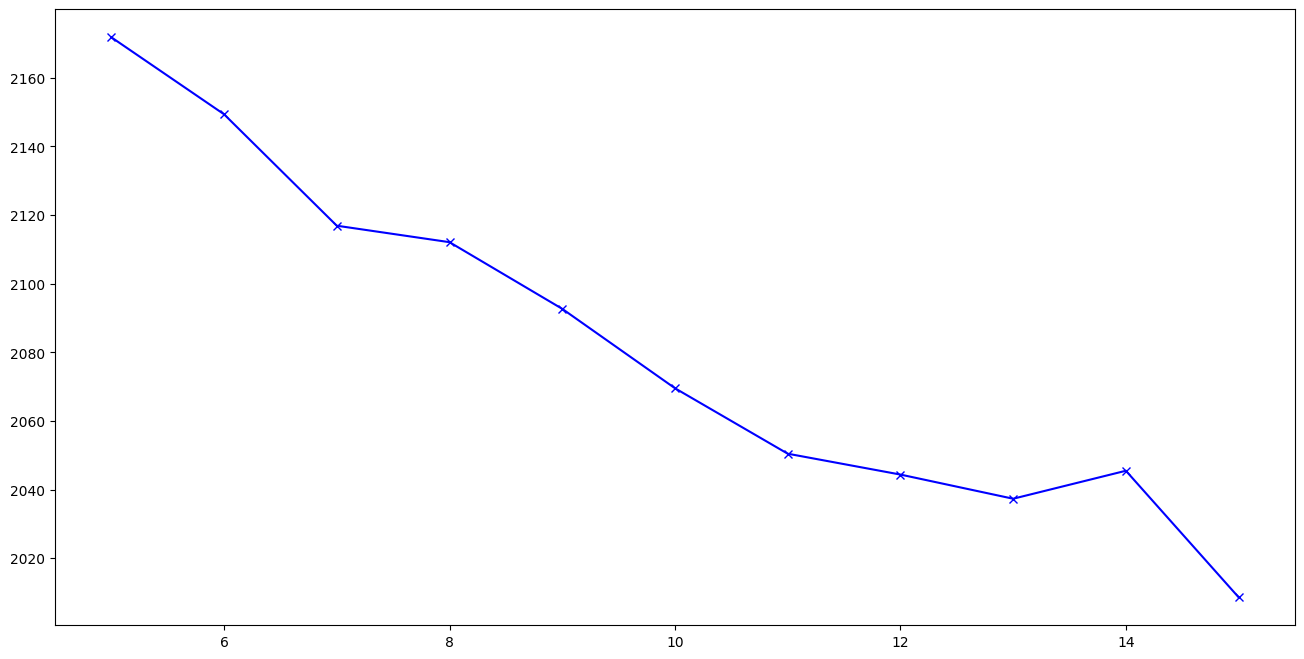

In [56]:
distortions = []

K = range(5, 16)
for k in K:
  kmean_model = KMeans(n_clusters=k)
  kmean_model.fit(X)
  distortions.append(kmean_model.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.show()

In [60]:
kmeans_final = KMeans(n_clusters=7)
kmeans_final.fit(X)
centroids_pred = kmeans_final.predict(X)
print(centroids_pred)
print(kmeans_final.cluster_centers_)

[3 3 5 3 3 2 3 5 5 5 3 5 0 2 0 0 0 0 0 5 0 0 0 0 0 2 0 0 3 0 5 0 5 0 0 3 0
 0 3 0 0 0 0 0 0 0 3 0 0 3 0 0 5 0 0 0 0 5 0 0 0 0 0 0 5 0 0 3 0 0 0 0 0 3
 3 0 5 0 3 0 5 3 3 3 0 0 0 0 0 0 5 0 5 2 5 3 0 5 3 4 0 0 0 3 3 2 5 4 5 3 4
 3 0 0 0 5 3 3 0 0 3 0 5 5 3 3 3 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 5 3 5 0 5
 0 5 3 5 3 5 3 5 5 3 3 5 3 3 3 5 0 3 0 3 3 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 0 0 0 3 0 3 0 0 2 5 2 3 2 5 2 2 2 2 2 2 5 5 1 1 6 6 1 1 1 1 6 1 1
 6 4 4 6 6 6 6 6 1 6 6 6 1 6 6 6 6 1 6 1 6 6 6 6 6 1 6 6 6 1 6 6 1 6 4 6 6
 6 5 2 4 5 2 5 5 2 2 2 3 6 6 6 6 6 1 1 6 1 4 4 6 0 5 2 4 4 4 1 3 3 3 3 2 2
 2 5 5 5 3 5 0 3 3 3 4 3 0 5 3 3 5 5 3 3 5 5 5 5 3 5 5 3 3 3 5 5 5 2 3 5 0
 3 5 2 5 4 4 4 5 2 4 2 4 1 4 1 1 6 6 1 6 6 2 3 4 2 4 2 4 4 2 3 3 2 2 2 3 3
 4 4 4 1 4 4 1 6 1 6 6 6 1 6 2 2 2 3 4 2 4 3 4 2 2 2 2 2 3 3 2 2 2 2 5 2 2
 2 2 3 2 2 5 4 4 6 1 6 6 6 4 1 6 1 6 1 2 2 2 2 4 4 5 2 5 6 4 4 4 1 6 6 6 6
 1 1 1 1 6 1 6 1 6 1 6 1 1 1 6 1 1 6 1 6 6 6 6 6 6 6 6 1 3 4 4 4 1 1 4 4 1
 3 5 5 5 3 0 2 5 5 2 3 2 

### DBSCAN

In [108]:
dbscan = DBSCAN(X, epsilon = 1.5 , minpts=5)
idx, noise = dbscan.run()
g_cluster, n_cluster = dbscan.sort()
print('Số cụm: ', len(g_cluster))
for i in range(len(g_cluster)):
  print(f'Số lượng mẫu trong cụm {i} là : {g_cluster[i][0].shape[0]}')
print('Số lượng nhiễu: ', len(n_cluster))

Số cụm:  2
Số lượng mẫu trong cụm 0 là : 187
Số lượng mẫu trong cụm 1 là : 36
Số lượng nhiễu:  588
